In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load CSV data (generated from the ESP32)
# CSV has no headers
df = pd.read_csv('stationary.csv', names=['accel_mean', 'accel_std', 'gyro_mean', 'gyro_std', 'temp'])

# 2. Preprocessing
# Autoencoders are sensitive to scale; we must normalize data to a standard range
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Split into training and validation sets (all should be "normal" data)
train_data, val_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

# 3. Build the Autoencoder Model
# Input (5 features) -> Compressed (2 features) -> Output (5 features)
input_dim = train_data.shape[1]
latent_dim = 2  # The "bottleneck" where data is compressed

autoencoder = models.Sequential([
    # Encoder
    layers.Dense(4, activation='relu', input_shape=(input_dim,)),
    layers.Dense(latent_dim, activation='relu'),

    # Decoder
    layers.Dense(4, activation='relu'),
    layers.Dense(input_dim, activation='linear') # Reconstruct original values
])

autoencoder.compile(optimizer='adam', loss='mse')

# 4. Train the Model
# Notice: Input and Output are the SAME (train_data) because it's unsupervised
history = autoencoder.fit(
    train_data, train_data,
    epochs=50,
    batch_size=16,
    validation_data=(val_data, val_data),
    verbose=1
)

# 5. Determine Anomaly Threshold
# Calculate the Mean Squared Error (MSE) on normal data
reconstructions = autoencoder.predict(train_data)
mse = np.mean(np.power(train_data - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95) # Set threshold at 95th percentile

print(f"Training Complete. Anomaly Threshold: {threshold}")

# 6. Save for TinyML Deployment
autoencoder.save("fatigue_model.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.4977 - val_loss: 3.0233
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5131 - val_loss: 3.0246
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4268 - val_loss: 3.0257
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4330 - val_loss: 3.0267
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4756 - val_loss: 3.0278
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.4728 - val_loss: 3.0289
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4748 - val_loss: 3.0300
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4193 - val_loss: 3.0311
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.4756 - val_loss: 3.0322
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4411 - val_loss: 3.0333
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4554 - val_loss: 3.0344
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.4923 - val_loss: 3.0354


Training Complete. Anomaly Threshold: 1.772832307902365


In [17]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
tflite_model = converter.convert()

# Save the TFLite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Generate a C-style hex dump for your Zephyr code
import os
os.system("xxd -i model.tflite > model_data.h")

Saved artifact at '/tmp/tmpmiw4unhp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136659285953232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285954384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285953040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285951504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285954960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285950736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285955344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136659285954192: TensorSpec(shape=(), dtype=tf.resource, name=None)


0

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_cnn_data(file_path, window_size=100):
    # 1. Load the labeled CSV
    # Format: accel_mean, accel_std, gyro_mean, gyro_std, temp, label
    df = pd.read_csv(file_path, names=['a_mean', 'a_std', 'g_mean', 'g_std', 'temp', 'label'])

    # 2. Separate Features and Labels
    features = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values

    # 3. Normalization (CRITICAL STEP)
    # We must scale the data so large values (like Temp) don't drown out small ones
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Print these out! You need to hardcode them in your ESP32 later
    print(f"Scaler Mean: {scaler.mean_}")
    print(f"Scaler Std: {scaler.scale_}")

    X = []
    y = []

    # 4. Sliding Window Formatting
    # We group rows into blocks of 100 to create the 3D shape
    for i in range(0, len(scaled_features) - window_size, 1):
        window = scaled_features[i : i + window_size]
        # We take the label of the last sample in the window as the window's label
        label = labels[i + window_size - 1]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)

# Execute formatting
X, y = prepare_cnn_data('synthetic_labeled_data.csv')

# 5. Validation Split
# 80% for Training, 20% for testing the model's accuracy on unseen data
# Before: X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# After: Added stratify=y to ensure all classes are in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training Shape: {X_train.shape}") # Should be (N, 100, 5)
print(f"Validation Shape: {X_val.shape}")

Scaler Mean: [10.16861631  2.18992693  1.0458362   0.50270241 30.34509955]
Scaler Std: [0.92505035 1.66408874 0.95093265 0.42027198 2.13042094]
Training Shape: (1120, 100, 5)
Validation Shape: (280, 100, 5)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build a lightweight 1D CNN for ESP32
model = models.Sequential([
    # Look for rhythmic patterns in the 100 samples
    layers.Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=(100, 5)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2), # Prevents overfitting
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax') # Outputs probabilities for 0, 1, and 2
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6234 - loss: 0.9030 - val_accuracy: 0.9250 - val_loss: 0.2935
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9239 - loss: 0.2683 - val_accuracy: 0.9643 - val_loss: 0.1113
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9661 - loss: 0.1192 - val_accuracy: 0.9714 - val_loss: 0.0899
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9788 - loss: 0.0869 - val_accuracy: 0.9857 - val_loss: 0.0495
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9806 - loss: 0.0687 - val_accuracy: 0.9929 - val_loss: 0.0372
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9771 - loss: 0.0624 - val_accuracy: 0.9964 - val_loss: 0.0322
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9898 - loss: 0.0484 - val_accuracy: 0.9857 - val_loss: 0.0316
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9864 - loss: 0.0484 - val_accuracy: 0.9964 - val_loss

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpe3i_89ip'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136585561568272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136585561570000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136585561571152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136585561569232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136585561568848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136585561570384: TensorSpec(shape=(), dtype=tf.resource, name=None)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


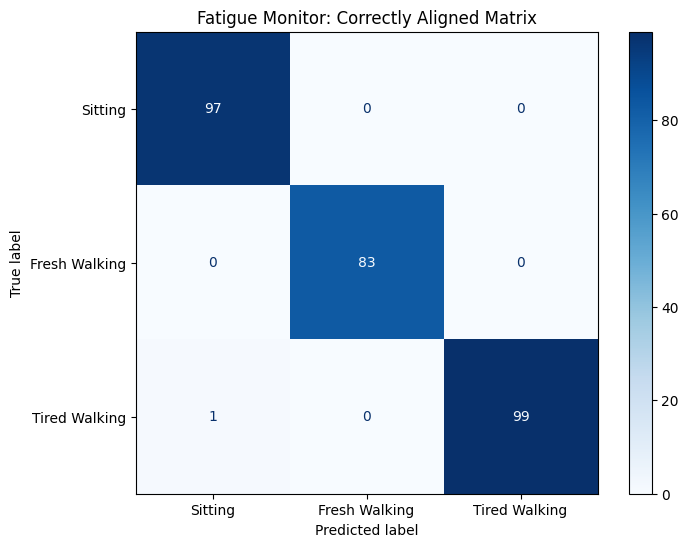

               precision    recall  f1-score   support

      Sitting       0.99      1.00      0.99        97
Fresh Walking       1.00      1.00      1.00        83
Tired Walking       1.00      0.99      0.99       100

     accuracy                           1.00       280
    macro avg       1.00      1.00      1.00       280
 weighted avg       1.00      1.00      1.00       280



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1. Generate predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Define standard labels and names
# CRITICAL: These must match your CSV labels (0=Sit, 1=Fresh, 2=Tired)
class_labels = [0, 1, 2]
class_names = ['Sitting', 'Fresh Walking', 'Tired Walking']

# 3. Compute the matrix using the explicit 'labels' parameter
# This ensures that even if a class has 0 samples, it still gets a row/column
cm = confusion_matrix(y_val, y_pred, labels=class_labels)

# 4. Plot using ConfusionMatrixDisplay for perfect alignment
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

plt.title('Fatigue Monitor: Correctly Aligned Matrix')
plt.show()

# 5. Print the report with the same explicit target names
print(classification_report(y_val, y_pred, labels=class_labels, target_names=class_names))

In [13]:
import os

def convert_tflite_to_h(tflite_path, header_path, array_name="g_model_data"):
    # 1. Read the binary TFLite file
    with open(tflite_path, 'rb') as f:
        tflite_content = f.read()

    # 2. Open the header file for writing
    with open(header_path, 'w') as f:
        f.write('#ifndef MODEL_DATA_H\n')
        f.write('#define MODEL_DATA_H\n\n')

        # Add alignment for the ESP32 FPU
        f.write('// Align to 16 bytes for hardware acceleration\n')
        f.write(f'const unsigned char {array_name}[] __attribute__((aligned(16))) = {{\n')

        # 3. Write bytes as hex values
        for i, byte in enumerate(tflite_content):
            f.write(f'0x{byte:02x}, ')
            if (i + 1) % 12 == 0:  # New line every 12 bytes for readability
                f.write('\n  ')

        f.write('\n};\n\n')
        f.write(f'const int {array_name}_len = {len(tflite_content)};\n\n')
        f.write('#endif // MODEL_DATA_H\n')

    print(f"Successfully converted {tflite_path} to {header_path}")
    print(f"Model size: {len(tflite_content)} bytes")

# Usage
convert_tflite_to_h('model.tflite', 'model_data.h')

Successfully converted model.tflite to model_data.h
Model size: 29440 bytes


In [12]:
import pandas as pd

# 1. Load the dataset
# Since the CSV doesn't have a header row, we assign names manually
column_names = ['Accel Mean', 'Accel Std', 'Gyro Mean', 'Gyro Std', 'Temp', 'Label']
df = pd.read_csv('labeled_data.csv', names=column_names)

# 2. Map numeric labels to descriptive text
# This makes the output much easier for humans to read
label_map = {0: 'Sitting', 1: 'Fresh Walking', 2: 'Tired Walking'}
df['Activity'] = df['Label'].map(label_map)

# 3. Calculate Feature Means
# Groupby 'Activity' collapses all rows of the same type into one row of averages
summary_stats = df.groupby('Activity')[['Accel Mean', 'Accel Std', 'Gyro Mean', 'Gyro Std', 'Temp']].mean()

# 4. Calculate Sample Counts
# This tells us how much data we have for each category
counts = df['Activity'].value_counts().rename('Sample Count')

# 5. Merge the data together
# We join the means and the counts into a single table
final_summary = summary_stats.merge(counts, left_index=True, right_index=True)

# 6. Save and Display
print("--- Activity Summary Table ---")
print(final_summary)
final_summary.to_csv('activity_summary.csv')

--- Activity Summary Table ---
               Accel Mean  Accel Std  Gyro Mean  Gyro Std       Temp  \
Activity                                                               
Fresh Walking   10.852317   2.752561   1.889512  0.889024  27.604268   
Sitting          9.696774   0.683355   0.534774  0.351484  32.066194   
Tired Walking   10.098158   3.150658   0.736842  0.285263  31.373684   

               Sample Count  
Activity                     
Fresh Walking            82  
Sitting                 155  
Tired Walking            76  


In [2]:
import pandas as pd
import numpy as np

# Load your original data
df = pd.read_csv('labeled_data.csv', header=None)
df.columns = ['Accel Mean', 'Accel Std', 'Gyro Mean', 'Gyro Std', 'Temp', 'Label']

def augment_sensor_data(df, target_count=500):
    new_data = []
    for label in df['Label'].unique():
        class_subset = df[df['Label'] == label]
        current_count = len(class_subset)
        to_add = target_count - current_count

        if to_add > 0:
            # Pick random existing rows to use as a base
            seeds = class_subset.sample(n=to_add, replace=True)
            features = seeds.iloc[:, :5].values

            # Calculate 5% jitter based on the class's own standard deviation
            stds = class_subset.iloc[:, :5].std().values
            noise = np.random.normal(0, stds * 0.05, features.shape)

            # Create synthetic rows
            synthetic_features = features + noise
            syn_df = pd.DataFrame(synthetic_features, columns=df.columns[:5])
            syn_df['Label'] = label
            new_data.append(syn_df)

    return pd.concat([df] + new_data, ignore_index=True)

# Generate and save
df_synthetic = augment_sensor_data(df, target_count=500)
df_synthetic.to_csv('synthetic_labeled_data.csv', index=False)